## Data Cleansing and Feature Engineering True and False News
Three satisfactory datasets with True and False news were found, and each needed a different degree of data cleansing.

To do our data classification text, we needed to have the following fields: full text, Truthvalue (boolean).  We also saved the dataset source in a source field, and created an index that would allow for finding the story in the original dataset in case we needed to do troubleshooting.  

Each file required different steps to arrive at the desired structure.

1) The buzzfeed-top.csv dataset at https://github.com/sfu-discourse-lab/Misinformation_detection/ consisted of 33 false stories.
After reading the csv file into a dataframe, In the FixupBuzzfeed() procedure below, we renamed some columns and set the truthvalue, source, and create an index.

2) The Snopes_checked_02 dataset at https://github.com/sfu-discourse-lab/Misinformation_detection/ needed similar modifications.

3) Rada Mihalcea (http://web.eecs.umich.edu/~mihalcea) FakeNewsDataset (http://web.eecs.umich.edu/~mihalcea/downloads.html#FakeNews) is an archive consisting of 980 files.

The data directory contains two fake news datasets:

- Celebrity
The fake and legitimate news are provided in two separate folders. The fake and legitimate labels are also provided as part of the filename.

- FakeNewsAMT
The fake and legitimate news are provided in two separate folders. Each folder contains 40 news from six different domains: technology, education, business, sports, politics, and entertainment. The file names indicate the news domain: business (biz), education (edu), entertainment (entmt), politics (polit), sports (sports) and technology (tech). The fake and legitimate labels are also provided as part of the filename.

The class and word distribution for the fake and legitimate news for each dataset is shown below

~~~
+-------------+------------+---------+---------------------+-------------+
|   Dataset   | Class      | Entries | Av. Words/Sentences | Total Words |
+-------------+------------+---------+---------------------+-------------+
|             | Fake       |   240   |        132/5        |    31,990   |
+ FakeNewsAMT +------------+---------+---------------------+-------------+
|             | Legitimate |   240   |        139/5        |    33,378   |
+-------------+------------+---------+---------------------+-------------+
|             | Fake       |   250   |        399/17       |    39,440   |
+  Celebrity  +------------+---------+---------------------+-------------+
|             | Legitimate |   250   |        700/33       |    70,975   |
+-------------+------------+---------+---------------------+-------------+
~~~

The ProcessMihalcea() function script below needed to iterate through each file and add it to the pandas dataframe.  It added a truthvalue field based on the directory name, saved the text in the text field, and created an index field based on the file name.

Once the three dataframes were created they were concatenated together and saved to object storage.

### Feature Engineering
The only real feature engineering was imputing the truthvalue as shown above.

In [1]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_buzzfeed = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'buzzfeed-top.csv'
}

credentials_snopes = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'snopes_checked_v02.csv'
}
credentials_mihalcea= {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'Mihalcea'
}

In [2]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.1.1)


In [3]:
from ibm_botocore.client import Config
import ibm_boto3
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
%matplotlib inline
pd.show_versions()




INSTALLED VERSIONS
------------------
commit           : f2ca0a2665b2d169c97de87b8e778dbed86aea07
python           : 3.6.9.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.15.0-112-generic
Version          : #113-Ubuntu SMP Thu Jul 9 23:41:39 UTC 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.1
numpy            : 1.18.5
pytz             : 2018.9
dateutil         : 2.7.5
pip              : 19.1.1
setuptools       : 49.6.0
Cython           : 0.29.5
pytest           : 4.2.1
hypothesis       : None
sphinx           : 1.8.4
blosc            : None
feather          : None
xlsxwriter       : 1.1.2
lxml.etree       : 4.3.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.10
IPython          : 7.2.0
pandas_datareader: None
bs4              : 4.7.1


In [4]:
def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')

In [5]:
def CsvToDf(file, **kwargs):
    df = pd.read_csv(file, **kwargs)
    #print (df.columns)
    return df

def FixUpBuzzfeed(df):
    # rename column 'original_article_text_phase2' to 'text'
    df = df.rename(columns={'original_article_text_phase2':'text'})
    # add 'source' column of "buzzfeed-top"
    bftl = ['buzzfeed-top'] * df.shape[0]
    df = df.assign(source = bftl)
    # add id column of buzzfeedrow_[#]
    zi = df.index
    ld = {k: 'buzzfeed_line_' + str(k)  for k in zi }
    df.rename(index = ld, inplace=True)
    # add 'TruthValue' column with value 0
    tv = [0]  * df.shape[0]
    df = df.assign(truthvalue = tv)
    df.drop(['title', 'url', 'Politifact', 'Politifact FB', 'Snopes', 'Snopes FB','Factcheck', 'Factcheck FB', 'ABC', 'ABC FB', 'error_phase2',
             'article_title_phase2','publish_date_phase2', 'author_phase2'],axis=1, inplace=True)

    return df

def FixUpSnopes(df):
    # rename original_article_text_phase2 column to text
    df = df.rename(columns={'original_article_text_phase2':'text'})
    # add 'source' column of "snopes-checked"
    bftl = ['snopes-checked'] * df.shape[0]
    df = df.assign(source = bftl)    
    # set id to 'snopes_line_
    zi = df.index
    ld = ld = {k: 'snopes_line_' + str(k)  for k in zi }
    df.rename(index = ld, inplace=True)
    # Only save true and false stories (remove mostly false, mostly true, and mixed)
    # add truthvalue column
    truedf = df[ df['fact_rating_phase1'] == 'TRUE' ]
    tv = [1] * truedf.shape[0]
    truedf = truedf.assign(truthvalue = tv) 

    falsedf = df[ df['fact_rating_phase1'] == 'FALSE']
    fv = [0] * falsedf.shape[0]
    falsedf = falsedf.assign(truthvalue = fv) 
    frames =[truedf, falsedf]
    df = pd.concat(frames)
    df.drop(['fact_rating_phase1', 'snopes_url_phase1', 'article_title_phase1', 'article_category_phase1', 'article_date_phase1', 'article_claim_phase1', 
            'article_origin_url_phase1', 'index_paragraph_phase1',  'page_is_first_citation_phase1', 'error_phase2', 
             'article_title_phase2', 'publish_date_phase2', 'author_phase2', 'Jerry-label', 'Jill-label', 'Fatemeh-label', 'notes', 'original order', 'Agreement'], 
             axis=1, inplace=True)
    #df.head()
    return df
    
def ProcessBuzzfeed(buzzcsv):
    print ("buzzfeed-top")
    dfBuzzfeedTop = CsvToDf(buzzcsv)
    dfBuzzfeedTop = FixUpBuzzfeed(dfBuzzfeedTop)
    print ("Rows: {} Columns: {} ColumnNames: {}".format(dfBuzzfeedTop.shape[0], dfBuzzfeedTop.shape[1], dfBuzzfeedTop.columns))
    return dfBuzzfeedTop
    
def ProcessSnopes(snopescsv):
    print ("snopes_checked_v02")
    dfSnopes_Checked = CsvToDf(snopescsv, encoding="ISO-8859-1", engine='python')
    dfSnopes_Checked = FixUpSnopes(dfSnopes_Checked)
    print ("Rows: {} Columns: {} ColumnNames: {}".format(dfSnopes_Checked.shape[0], dfSnopes_Checked.shape[1], dfSnopes_Checked.columns))
    return dfSnopes_Checked

def ProcessMihalcea(mihalceaNewsDirName, mihalceaCelebDirName):
    #mihalceaNewsDirs = glob.glob(R"..\dataset\Mihalcea\fakeNewsDataset")
    #mihalceaCelebDirs = glob.glob(R"..\dataset\Mihalcea\celebrityDataset")
    mihalceaNewsDirs = glob.glob(mihalceaNewsDirName)
    mihalceaCelebDirs = glob.glob(mihalceaCelebDirName)

    mihalFakeDict = {}
    mihalLegitDict ={}
    for b in glob.glob(mihalceaNewsDirName + "fake/*"):
        #print (a,b)
        with open(b, 'r') as myfile:
            data = myfile.read().replace('\n', ' ')
        ididx = re.search(r"[a-z]+[0-9]+", b).span()
        _id = b[ididx[0]: ididx[1]] + 'fake'
        item  = {}
        item['text'] = data
        item['source'] = "MihalceaNewsFake"
        item['truthvalue'] = 0
        mihalFakeDict[_id]=  item
    for b in glob.glob(mihalceaNewsDirName + "legit/*"):
        #print (a,b)
        with open(b, 'r') as myfile:
            data = myfile.read().replace('\n', ' ')
        ididx = re.search(r"[a-z]+[0-9]+", b).span()
        _id = b[ididx[0]: ididx[1]] + 'legit'
        item  = {}
        item['text'] = data
        item['source'] = "MihalceaNewsLegit"
        item['truthvalue'] = 1
        mihalLegitDict[_id]=  item

    for b in glob.glob(mihalceaCelebDirName + "fake/*"):
        #print (a,b)
        with open(b, 'r', encoding='utf-8') as myfile:
            data = myfile.read().replace('\n', ' ')
        ididx = re.search(r"[0-9]+[a-z]+", b).span()
        _id = 'celeb' + b[ididx[0]: ididx[1]]
        item  = {}
        item['source'] = "MihalceaCelebFake"
        item['text'] = data
        item['truthvalue'] = 0
        mihalFakeDict[_id]=  item
    for b in glob.glob(mihalceaCelebDirName + "legit/*"):
        #print (a,b)
        with open(b, 'r', encoding='utf-8') as myfile:
            data = myfile.read().replace('\n', ' ')
        ididx = re.search(r"[0-9]+[a-z]+", b).span()
        _id = 'celeb' + b[ididx[0]: ididx[1]]
        item  = {}
        item['source'] = "MihalceaCelebLegit"
        item['text'] = data
        item['truthvalue'] = 1
        mihalLegitDict[_id]=  item

    dfMihalFake = pd.DataFrame(mihalFakeDict)
    dfMihalFake = dfMihalFake.transpose()
    print ("Rows: {} Columns: {} Columnnames: {}".format(dfMihalFake.shape[0], dfMihalFake.shape[1], dfMihalFake.columns))
    print (dfMihalFake.columns)


    dfMihalLegit = pd.DataFrame(mihalLegitDict)
    dfMihalLegit = dfMihalLegit.transpose()

    print (dfMihalLegit.columns)
    print ("Rows: {} Columns: {} Columnnames: {}".format(dfMihalLegit.shape[0], dfMihalLegit.shape[1], dfMihalLegit.columns))
    return dfMihalLegit, dfMihalFake



In [6]:
download_file_cos(credentials_buzzfeed,'buzzfeed-top.csv','buzzfeed-top.csv')
dfBuzzfeedTop = ProcessBuzzfeed('buzzfeed-top.csv')

download_file_cos(credentials_snopes, 'snopes_checked_v02.csv','snopes_checked_v02.csv')
dfSnopes_Checked = ProcessSnopes('snopes_checked_v02.csv')

File Downloaded
buzzfeed-top
Rows: 33 Columns: 3 ColumnNames: Index(['text', 'source', 'truthvalue'], dtype='object')
File Downloaded
snopes_checked_v02
Rows: 116 Columns: 3 ColumnNames: Index(['text', 'source', 'truthvalue'], dtype='object')


In [7]:
download_file_cos(credentials_mihalcea, 'Mihalcea_fakeNewsDatasets.zip','Mihalcea_fakeNewsDatasets.zip')
!ls
#!rm -r mihalcea
!mkdir mihalcea
!unzip Mihalcea_fakeNewsDatasets.zip -d mihalcea
!ls mihalcea

File Downloaded
buzzfeed-top.csv     Mihalcea_fakeNewsDatasets.zip
dfTrueFalseNews.pkl  snopes_checked_v02.csv
Archive:  Mihalcea_fakeNewsDatasets.zip
   creating: mihalcea/fakeNewsDatasets/
   creating: mihalcea/fakeNewsDatasets/celebrityDataset/
   creating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/001fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/002fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/003fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/004fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/005fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/006fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/007fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/008fake.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/fake/009fake.txt  
  inflating: mi

  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/078legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/079legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/080legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/081legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/082legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/083legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/084legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/085legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/086legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/087legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/088legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/089legit.txt  
  inflating: mihalcea/fakeNewsDatasets/celebrityDataset/legit/090legit.txt  

  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports30.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports31.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports32.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports33.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports34.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports35.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports36.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports37.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports38.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports39.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/sports40.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fakeNewsDataset/fake/tech001.fake.txt  
  inflating: mihalcea/fakeNewsDatasets/fa

fakeNewsDatasets


In [8]:
dfMihalLegit, dfMihalFake = ProcessMihalcea("mihalcea/fakeNewsDatasets/fakeNewsDataset/", 'mihalcea/fakeNewsDatasets/celebrityDataset/')

Rows: 490 Columns: 3 Columnnames: Index(['text', 'source', 'truthvalue'], dtype='object')
Index(['text', 'source', 'truthvalue'], dtype='object')
Index(['text', 'source', 'truthvalue'], dtype='object')
Rows: 490 Columns: 3 Columnnames: Index(['text', 'source', 'truthvalue'], dtype='object')


In [9]:
# df: dfMihalLegit, dfMihalFake, dfBuzzfeedTop, dfSnopes_Checked
frames =[dfMihalLegit, dfMihalFake, dfBuzzfeedTop, dfSnopes_Checked]
dfTrueFalseNews = pd.concat(frames)

print (dfTrueFalseNews.columns)
print ("Rows: {} Columns: {}".format(dfTrueFalseNews.shape[0], dfTrueFalseNews.shape[1]))
dfTrueFalseNews.to_pickle("dfTrueFalseNews.pkl", protocol=4 ) # use protocol 4 to maintain compatibility with Watson Studio Python 3.6

Index(['text', 'source', 'truthvalue'], dtype='object')
Rows: 1129 Columns: 3


In [10]:
upload_file_cos(credentials_buzzfeed,"dfTrueFalseNews.pkl","dfTrueFalseNews.pkl")

 File Uploaded


Index(['text', 'source', 'truthvalue'], dtype='object') (1129, 3)


Text(0, 0.5, 'Article Counts')

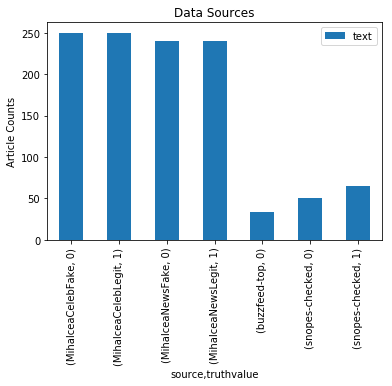

In [11]:
dfTrueFalseNews = pd.read_pickle('dfTrueFalseNews.pkl')
print (dfTrueFalseNews.columns, dfTrueFalseNews.shape)
dfTrueFalseNews.groupby(['source', 'truthvalue']).count().plot(kind='bar')
plt.title("Data Sources")
plt.ylabel("Article Counts")